In [1]:
%load_ext zipline

In [2]:
%load_ext watermark

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. Импортируем библиотеки

In [4]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)

# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# графика
import matplotlib.pyplot as plt
from matplotlib import style

# работа с временем
from datetime import datetime

# aинансовые данные
from yahoofinancials import YahooFinancials

# ignore warnings
import warnings

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

In [5]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
%watermark --iversions

pyfolio 0.9.2
pytz    2016.6.1
zipline v1.3.0
pandas  0.22.0
numpy   1.11.3



# 2. Загрузка данных

In [7]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close','volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green');

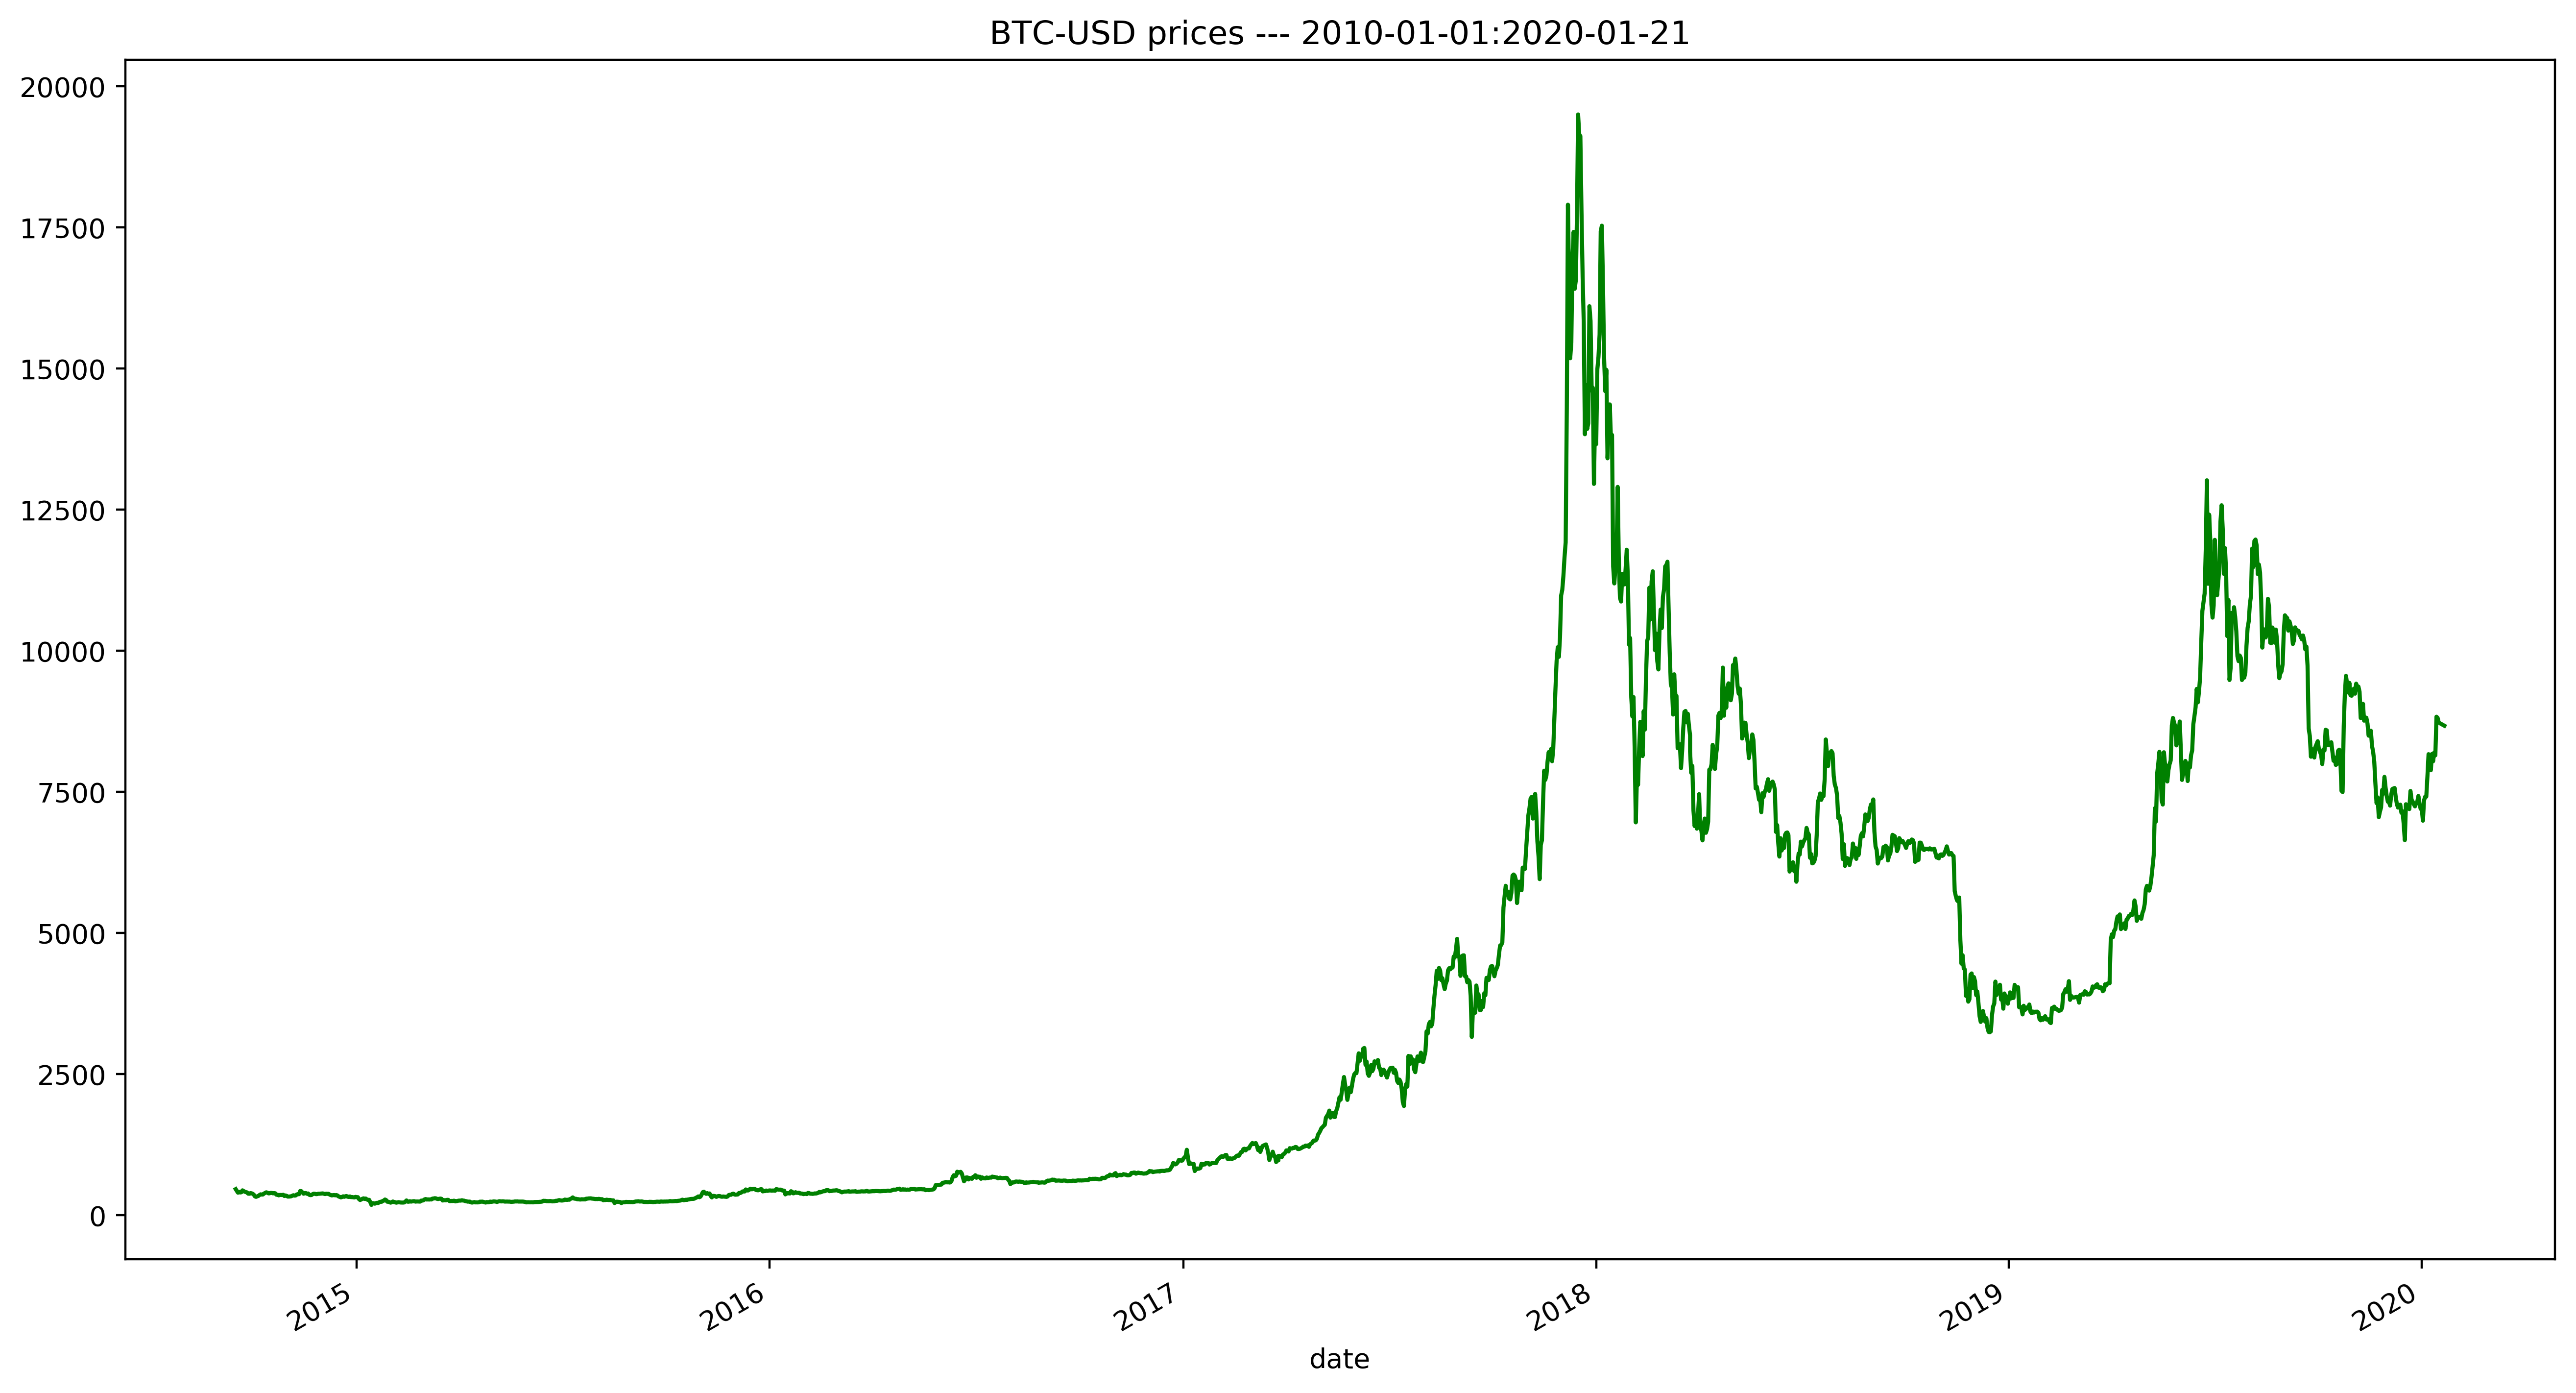

In [8]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2010-01-01', 
                  end_date='2020-01-21', 
                  freq='daily', 
                  path='data/BTC.csv')

In [9]:
data = OrderedDict()

tikers = ['BTC']

for tiker in tikers:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][["open","high","low","close","volume"]]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

                  open        high         low       close      volume
date                                                                  
2014-09-16  465.864014  468.174011  452.421997  457.334015  21056800.0
2014-09-17  456.859985  456.859985  413.104004  424.440002  34483200.0
2014-09-18  424.102997  427.834991  384.532013  394.795990  37919700.0
2014-09-19  394.673004  423.295990  389.882996  408.903992  36863600.0
2014-09-20  408.084991  412.425995  393.181000  398.821014  26580100.0


In [11]:
data['BTC'].tail()

,open,high,low,close,volume
date,,,,,
2020-01-17,8812.481445,8846.460938,8612.095703,8723.786133,3.131398e+10
2020-01-18,8812.481445,8846.460938,8612.095703,8723.786133,3.131398e+10
2020-01-19,8812.481445,8846.460938,8612.095703,8723.786133,3.131398e+10
2020-01-20,8812.481445,8846.460938,8612.095703,8723.786133,3.131398e+10
2020-01-21,8652.845703,8687.793945,8624.917969,8667.510742,2.311192e+10


In [12]:
panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 1954 (major_axis) x 5 (minor_axis)
Items axis: BTC to BTC
Major_axis axis: 2014-09-16 00:00:00+00:00 to 2020-01-21 00:00:00+00:00
Minor_axis axis: open to volume


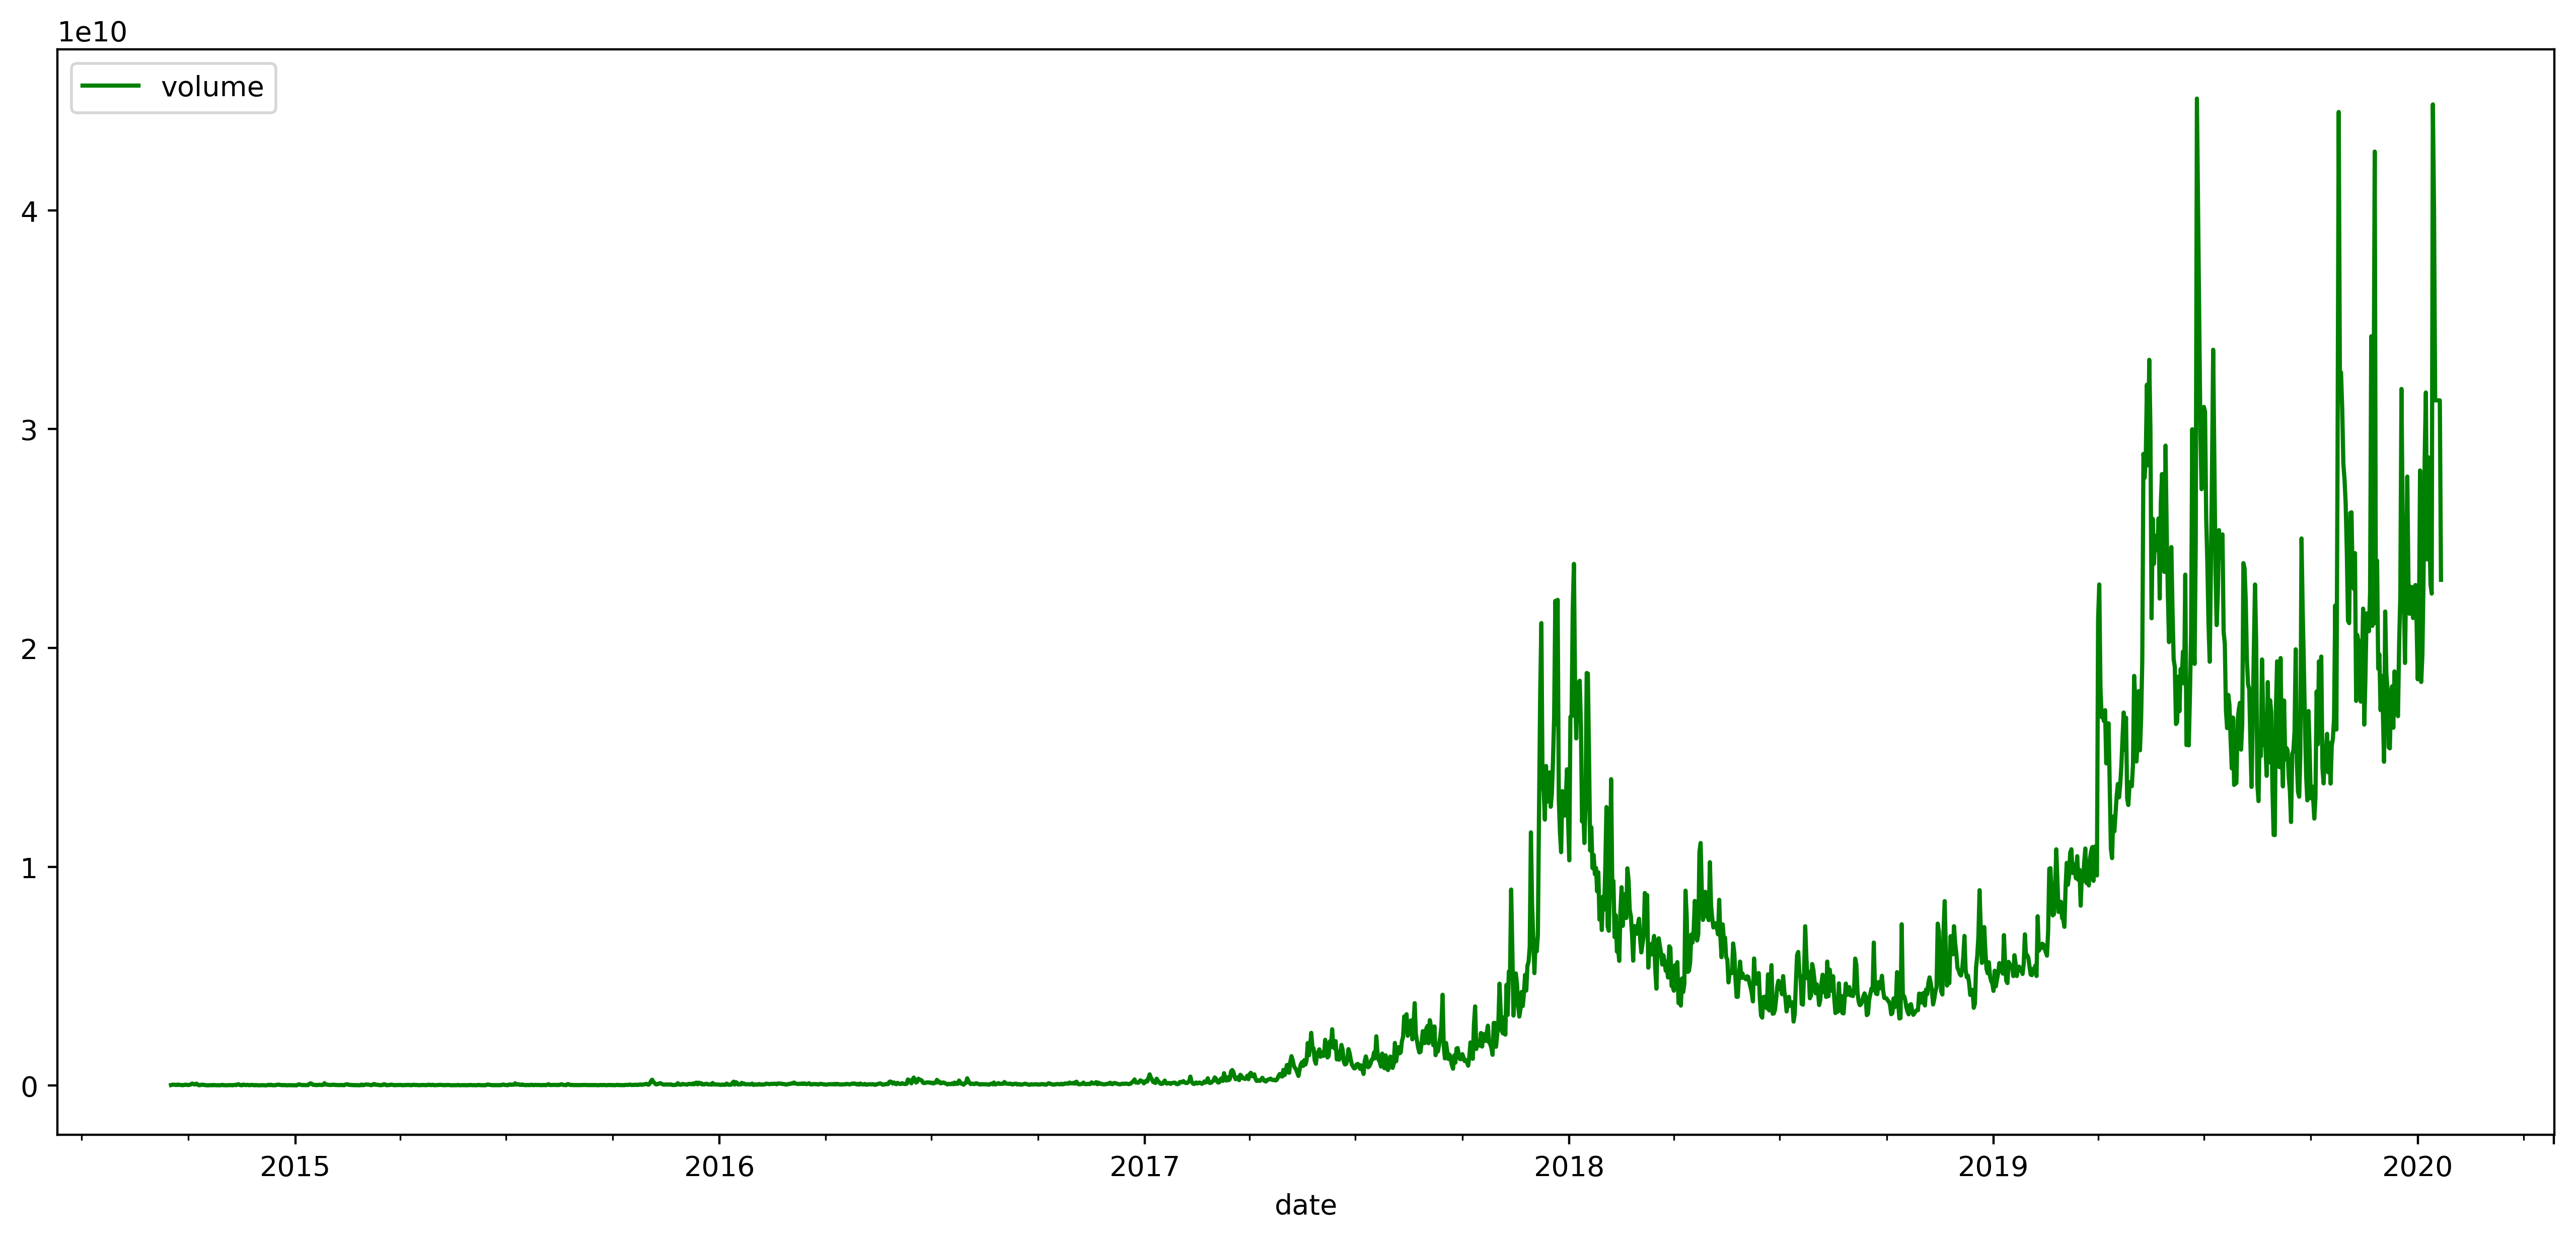

In [14]:
fig, ax = plt.subplots(figsize=[16, 7])

data['BTC']['volume'].plot(color='g')

plt.legend()
plt.show()

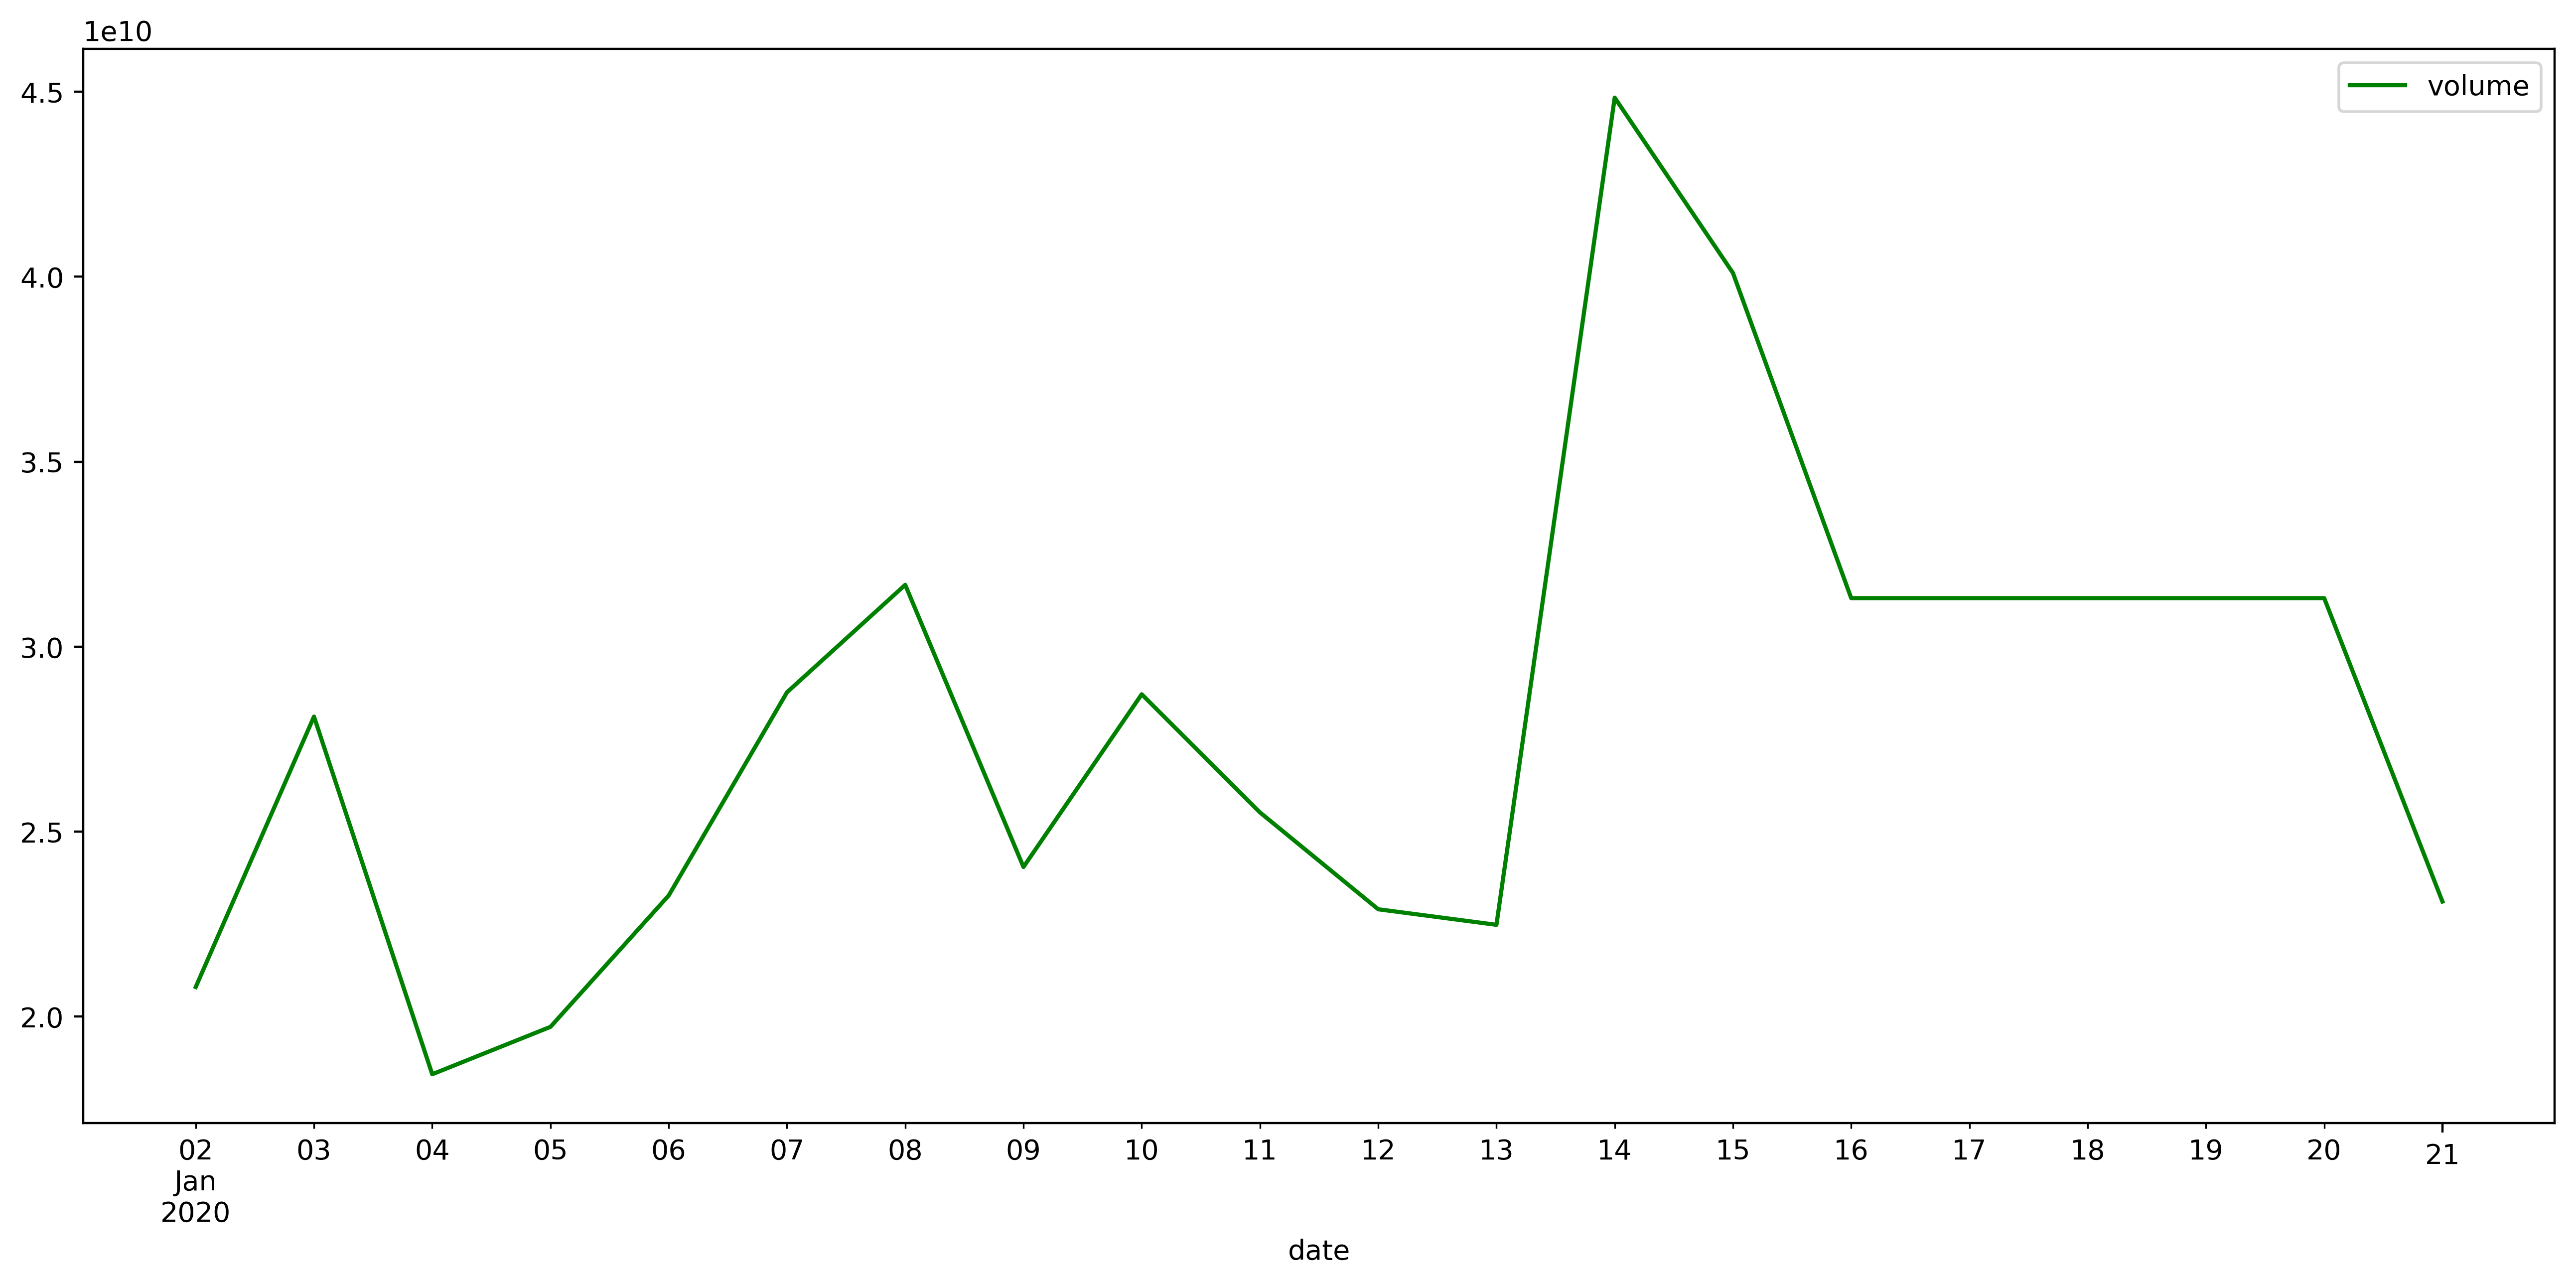

2020 mean =  27954677824.0


In [31]:
fig, ax = plt.subplots(figsize=[16, 7])

data['BTC']['volume'][-1:-21:-1].plot(color='g')

plt.legend()
plt.show()

print('2020 mean = ', np.round(data['BTC']['volume'][-1:-21:-1].mean()))

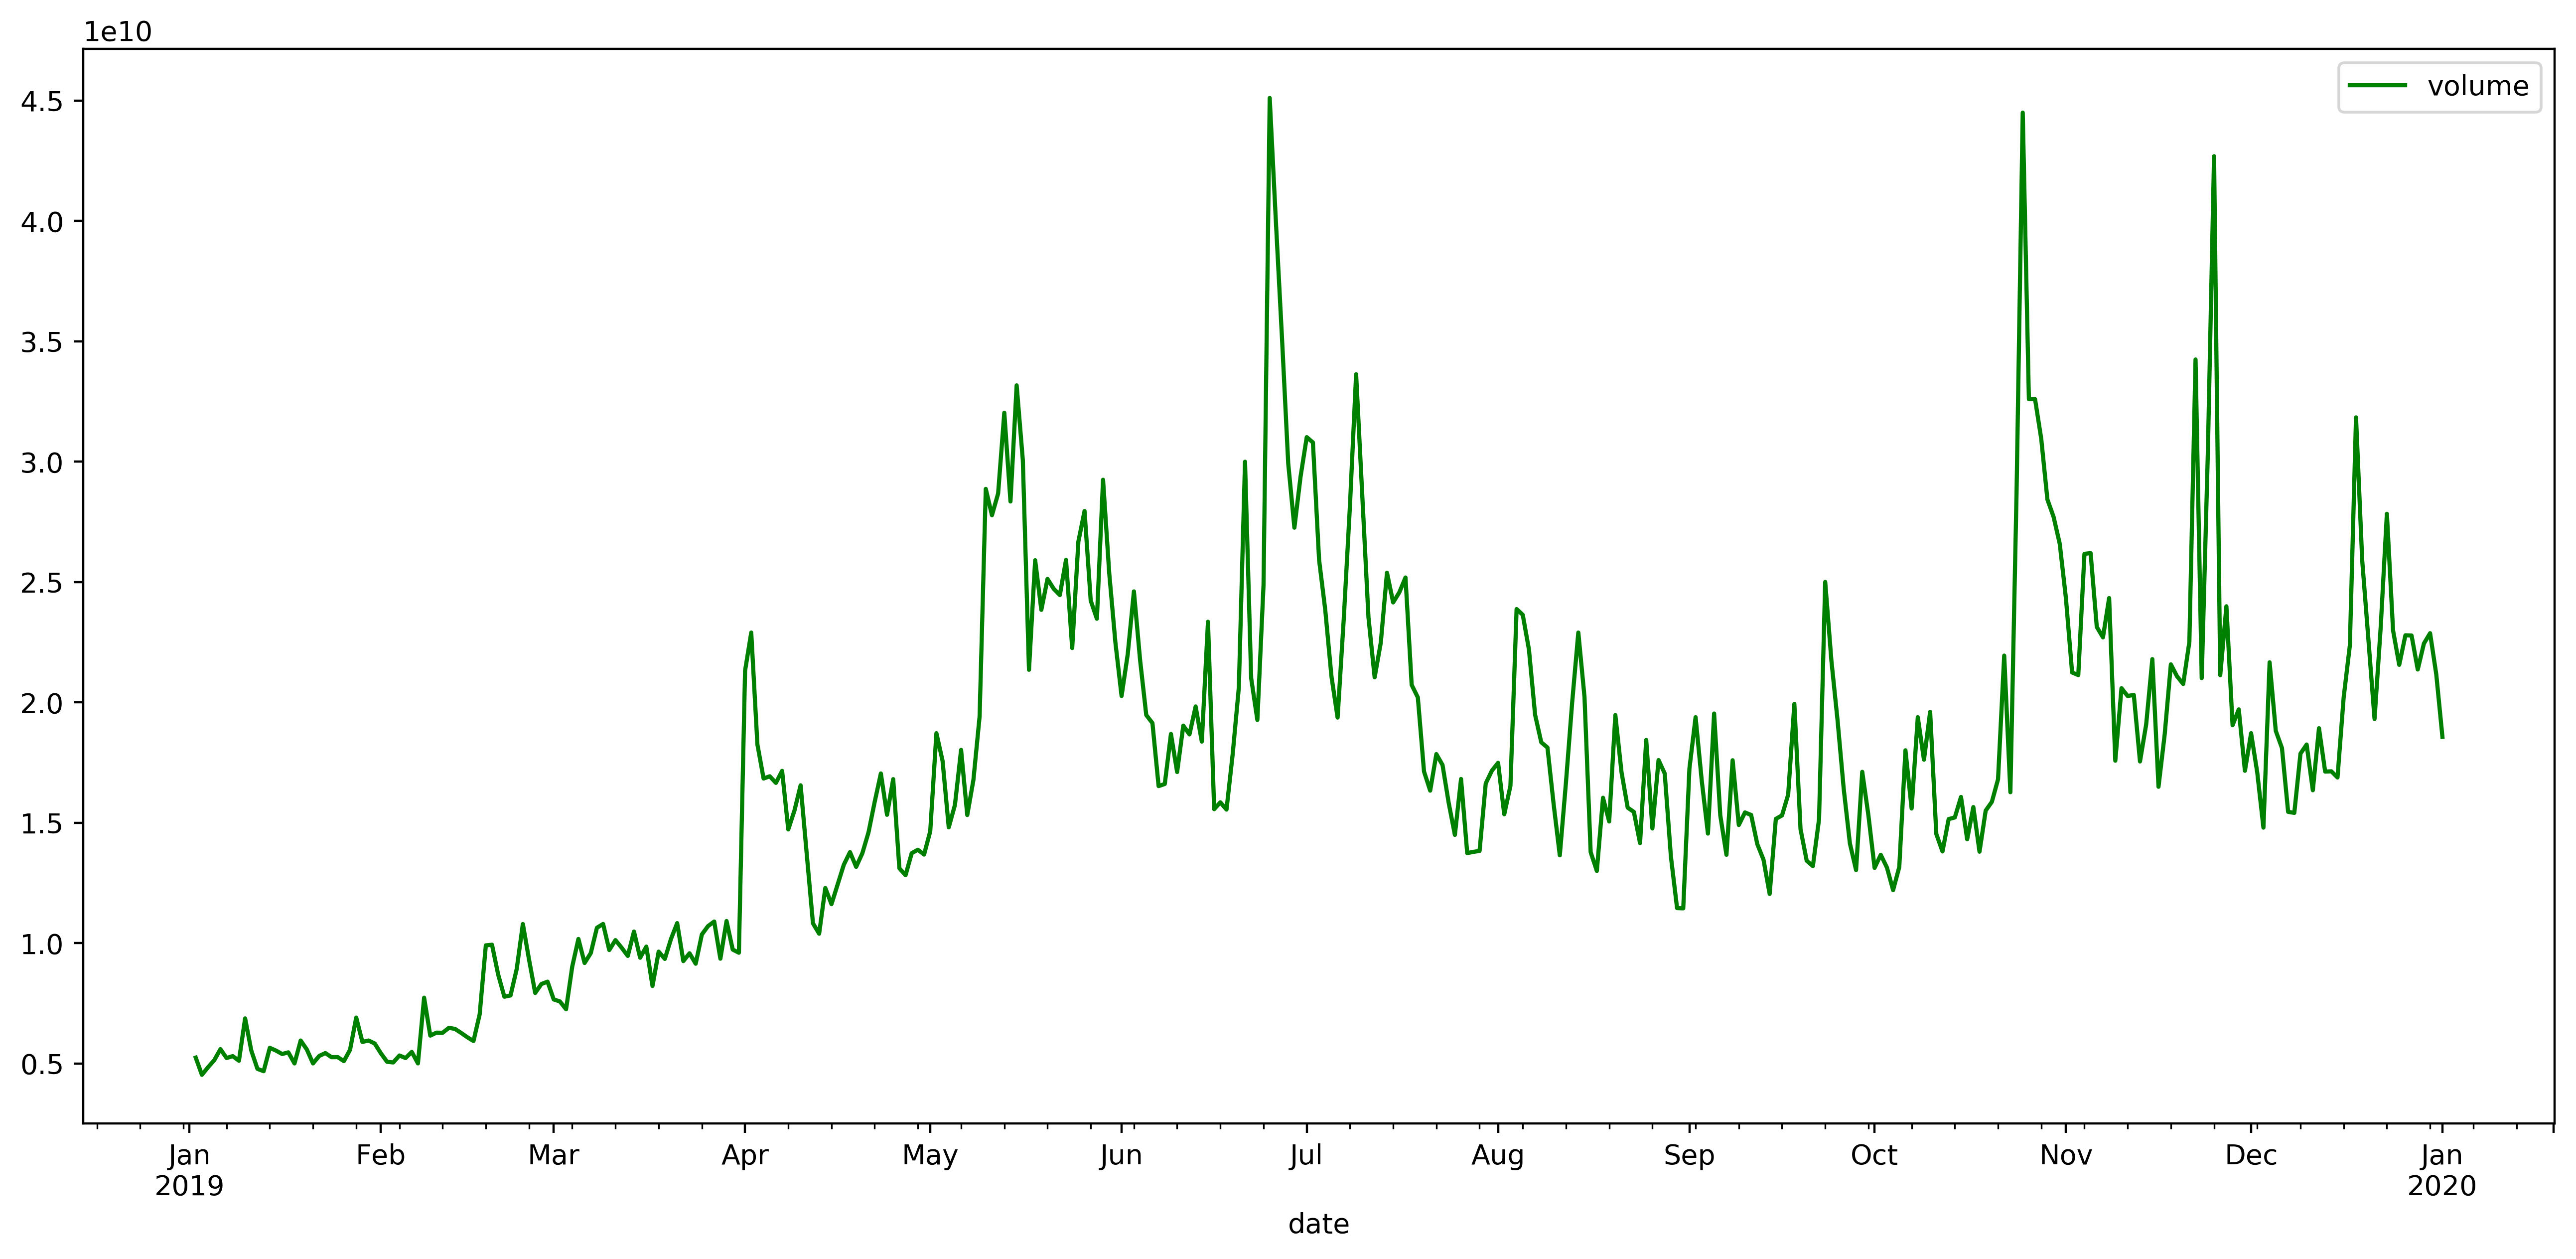

2019 mean =  16832497024.0


In [32]:
fig, ax = plt.subplots(figsize=[16, 7])

data['BTC']['volume'][-21:-386:-1].plot(color='g')

plt.legend()
plt.show()

print('2019 mean = ', np.round(data['BTC']['volume'][-21:-386:-1].mean()))

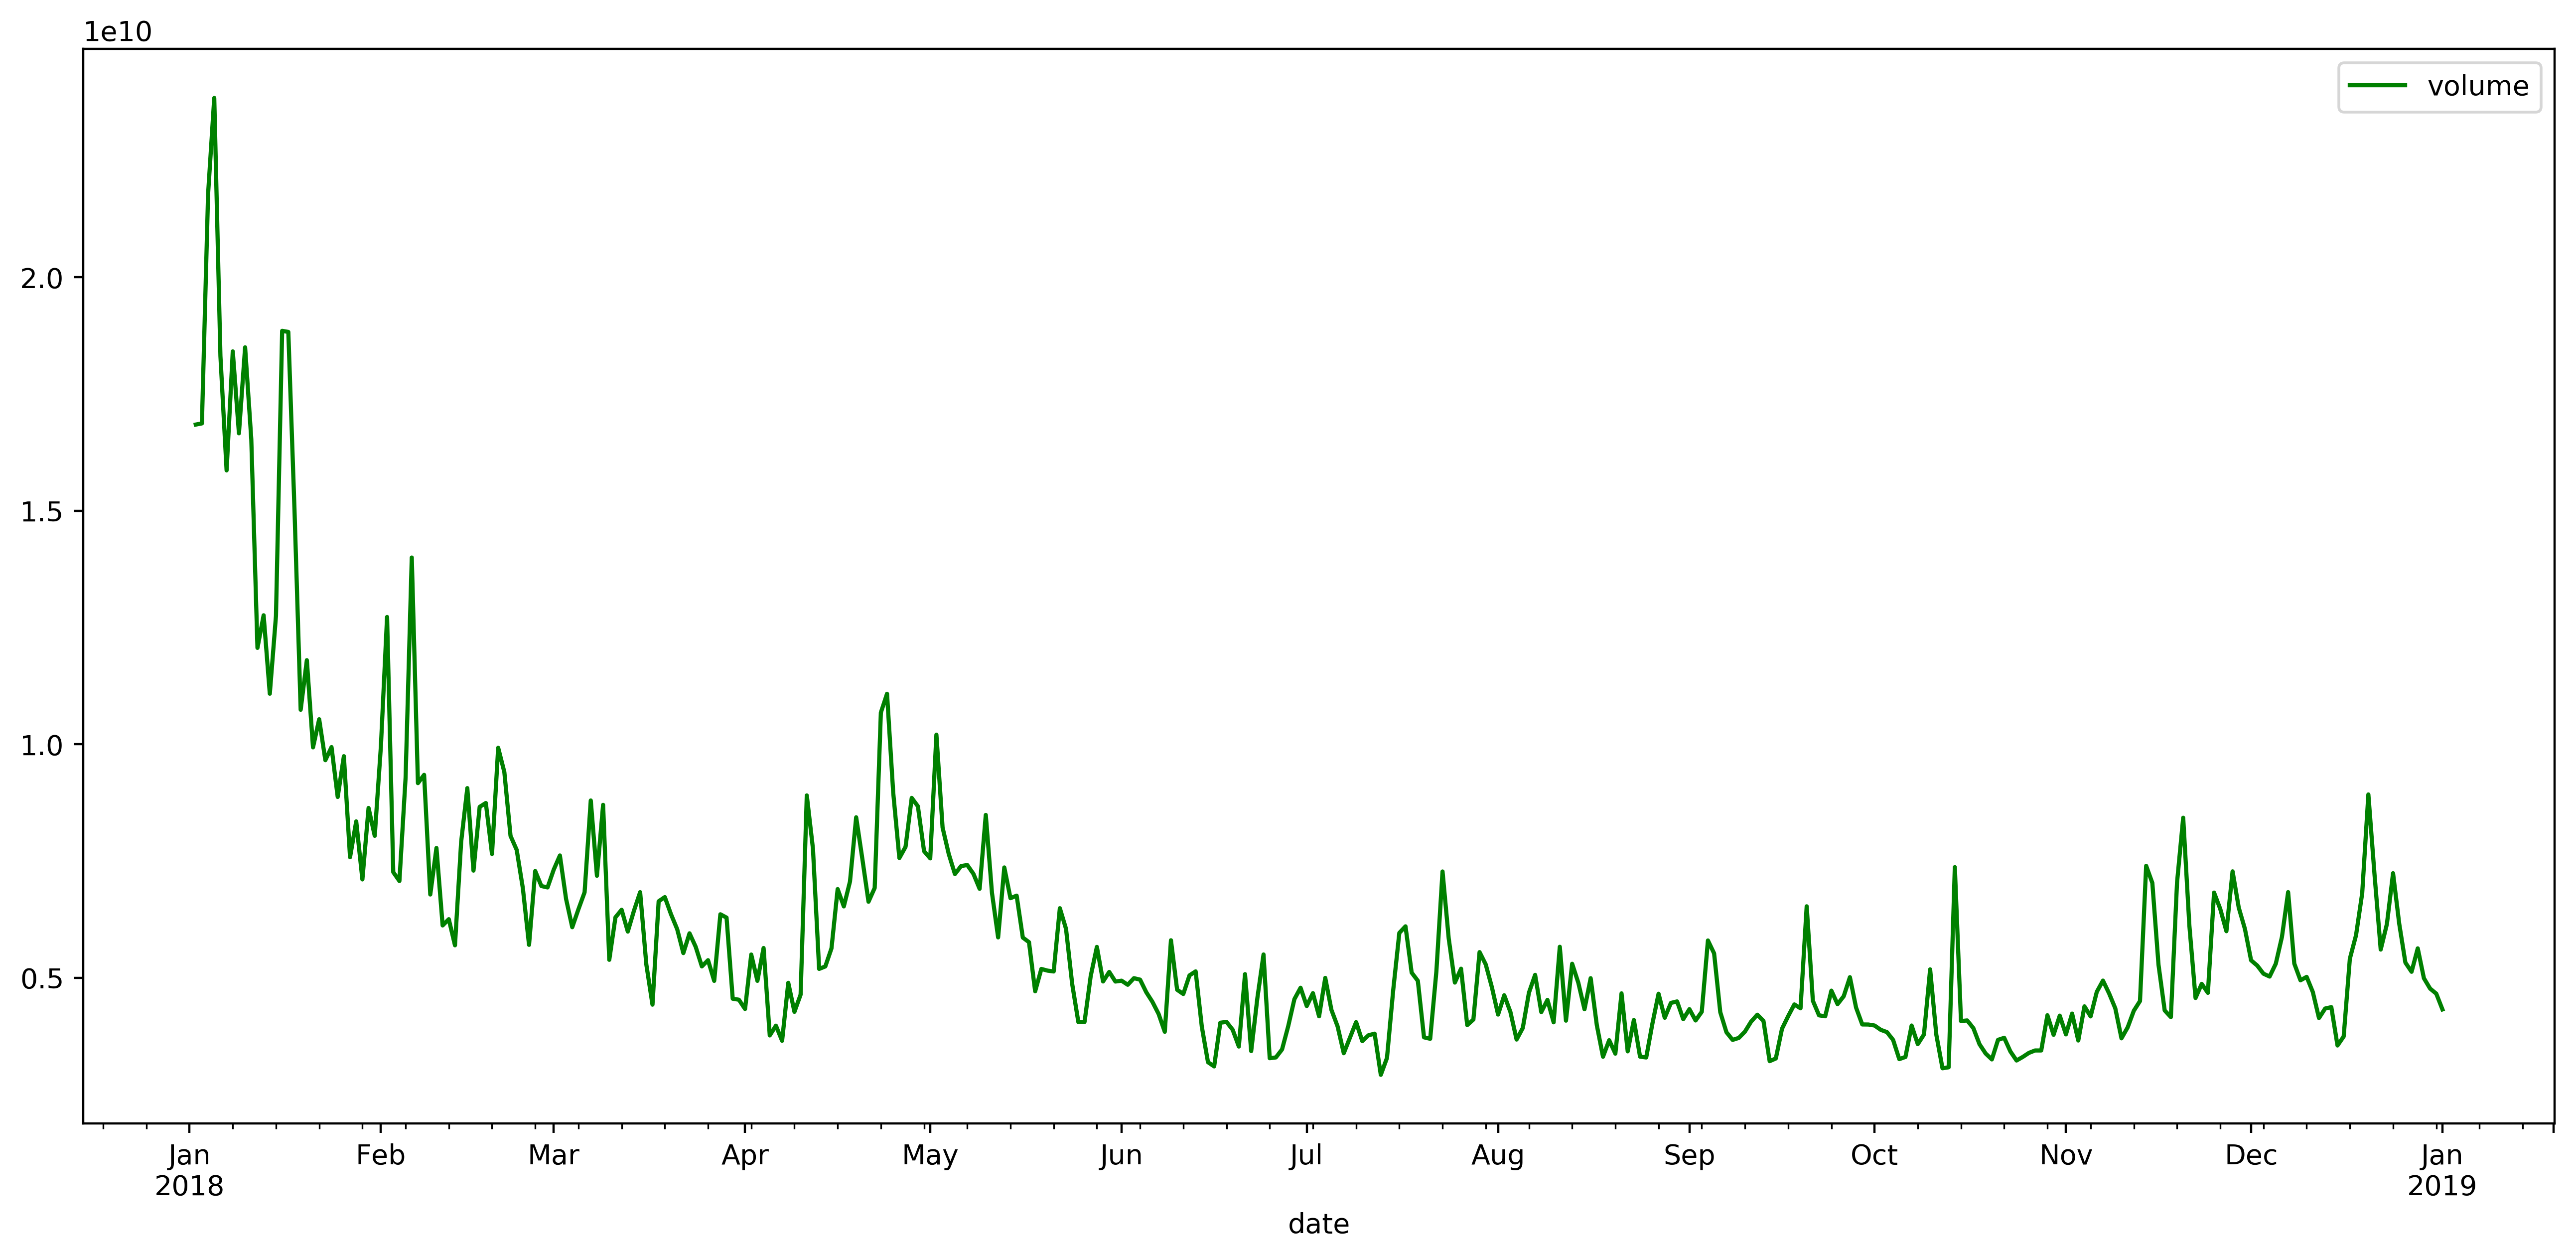

2018 mean =  6042271978.0


In [33]:
fig, ax = plt.subplots(figsize=[16, 7])

data['BTC']['volume'][-386:-751:-1].plot(color='g')

plt.legend()
plt.show()

print('2018 mean = ', np.round(data['BTC']['volume'][-386:-751:-1].mean()))

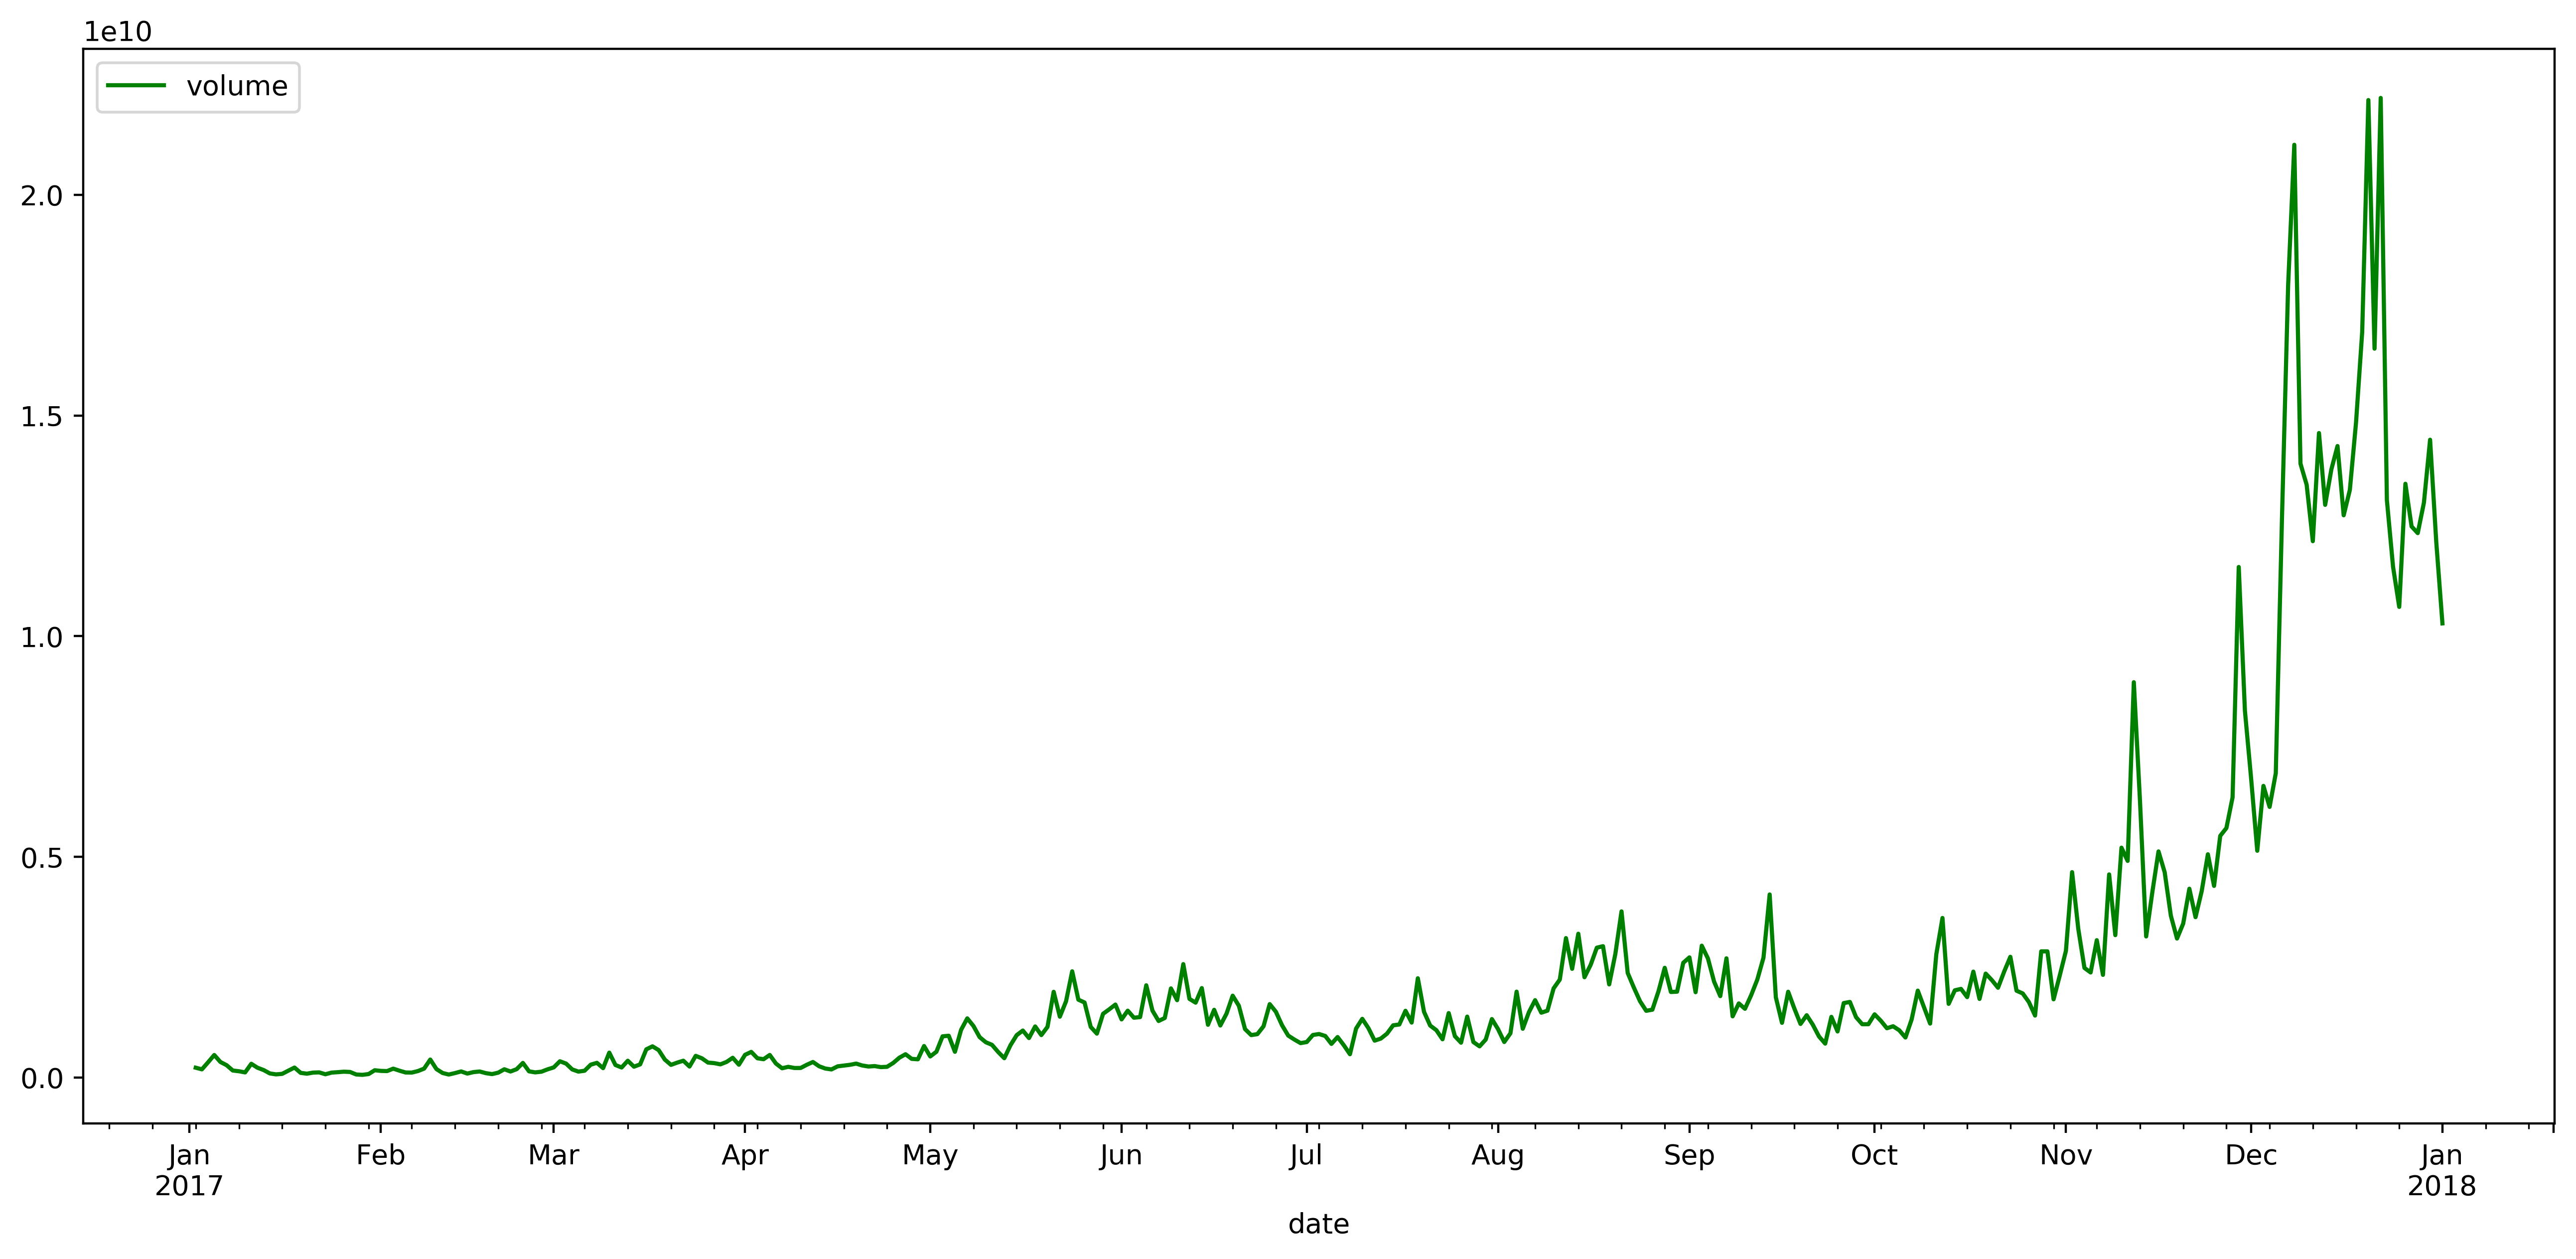

2017 mean =  2417563793.0


In [34]:
fig, ax = plt.subplots(figsize=[16, 7])

data['BTC']['volume'][-751:-1116:-1].plot(color='g')

plt.legend()
plt.show()

print('2017 mean = ', np.round(data['BTC']['volume'][-751:-1116:-1].mean()))

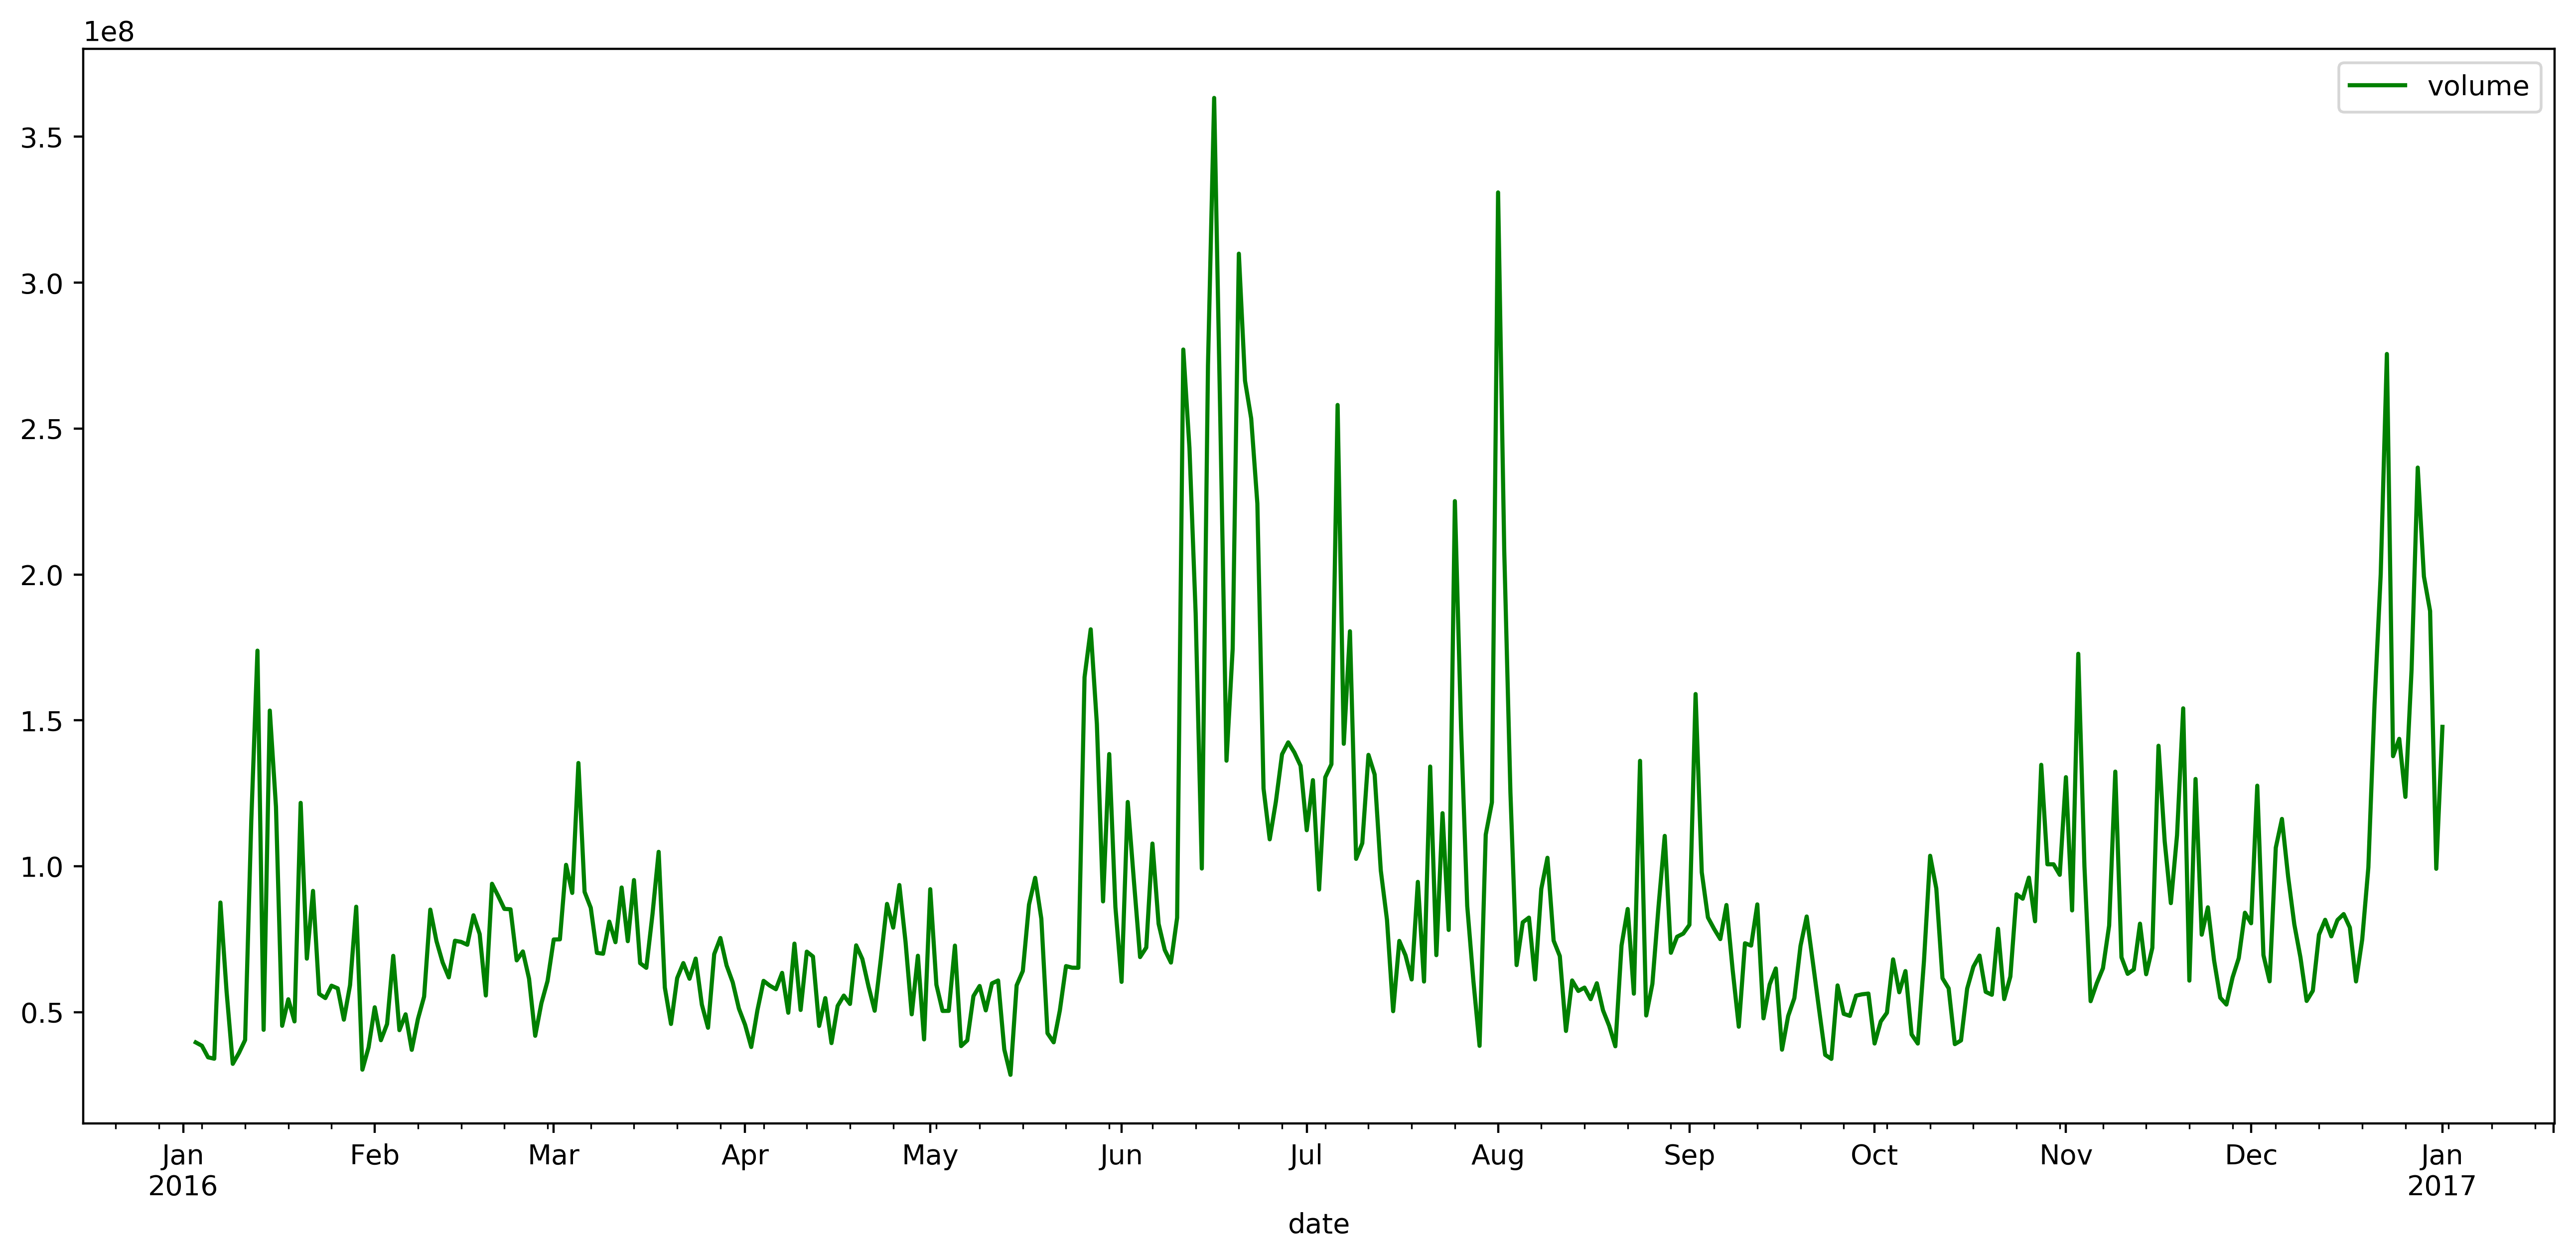

2016 mean =  86467286.0


In [35]:
fig, ax = plt.subplots(figsize=[16, 7])

data['BTC']['volume'][-1116:-1481:-1].plot(color='g')

plt.legend()
plt.show()

print('2016 mean = ', np.round(data['BTC']['volume'][-1116:-1481:-1].mean()))